Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.0167 - val_loss: 0.0041
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0011 - val_loss: 9.7586e-04
Epoch 10/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 12/20
244/244 ━━━━━━━━━━━━━━━━

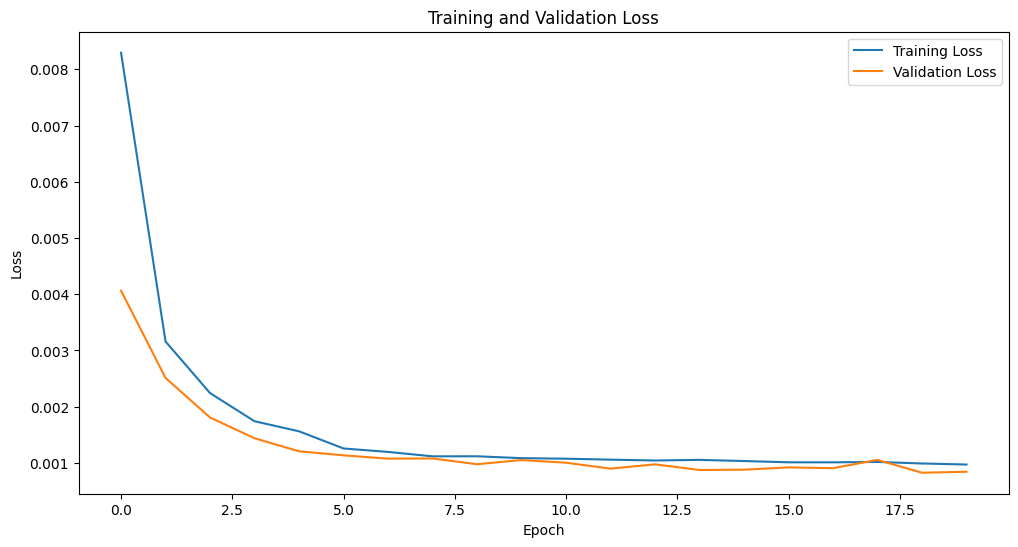

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Mean Absolute Error (MAE): 7.273171838567837
Mean Squared Error (MSE): 121.99151440015166
Root Mean Squared Error (RMSE): 11.044976885451216
Accuracy: 0.9573921971252567
F1 Score: 0.9303106633081444
Confusion Matrix:
[[1311   19]
 [  64  554]]


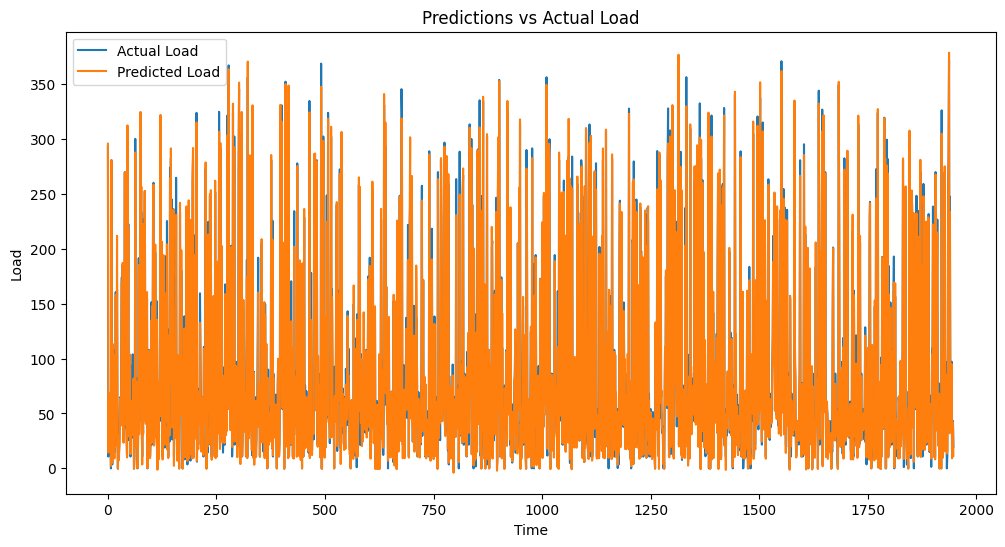

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt

# Load the datasets
file_paths = [
    'Dataset 1_EV charging reports_cleaned.csv',
    'Dataset 2_Hourly EV loads - Per user_cleaned.csv',
    'Dataset 3a_Hourly EV loads - Aggregated private_cleaned.csv',
    'Dataset 3b_Hourly EV loads - Aggregated shared_cleaned.csv',
    'Dataset 5_AMS data from garage Bl2_cleaned.csv',
    'Dataset 6_Local traffic distribution_cleaned.csv',
    'Norway_Trondheim_ExactLoc_Weather.csv'
]

dataframes = [pd.read_csv(file) for file in file_paths]

# Select Dataset 2 for prediction
ev_loads_per_user = dataframes[1]

# Preprocessing steps
# Convert date_from and date_to to datetime objects
ev_loads_per_user['date_from'] = pd.to_datetime(ev_loads_per_user['date_from'], format='%d.%m.%Y %H:%M')
ev_loads_per_user['date_to'] = pd.to_datetime(ev_loads_per_user['date_to'], format='%d.%m.%Y %H:%M')

# Convert load columns to numeric values (handling commas and converting to float)
load_columns = ['Synthetic_3_6kW', 'Synthetic_7_2kW', 'Flex_3_6kW', 'Flex_7_2kW']
for column in load_columns:
    ev_loads_per_user[column] = ev_loads_per_user[column].str.replace(',', '.').astype(float)

# Handle missing values by filling them with 0
ev_loads_per_user[load_columns] = ev_loads_per_user[load_columns].fillna(0)

# Extract hour from 'date_from'
ev_loads_per_user['hour'] = ev_loads_per_user['date_from'].dt.floor('h')

# Aggregating data by hour and summing only the load columns
ev_loads_per_hour = ev_loads_per_user.groupby('hour')[load_columns].sum().reset_index()

# Define the target variable (total load as the sum of all load columns)
ev_loads_per_hour['total_load'] = ev_loads_per_hour[load_columns].sum(axis=1)

# Select features and target
features = ev_loads_per_hour[['hour'] + load_columns]
target = ev_loads_per_hour['total_load']

# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features[load_columns])
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

# Create sequences for LSTM (using a window of 24 hours)
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(features_scaled, target_scaled, window_size)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(window_size, len(load_columns))))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate regression evaluation metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Convert regression outputs to binary classification
threshold = np.mean(y_test_actual)
y_test_class = (y_test_actual > threshold).astype(int)
predictions_class = (predictions > threshold).astype(int)

# Calculate classification metrics
accuracy = accuracy_score(y_test_class, predictions_class)
f1 = f1_score(y_test_class, predictions_class)
conf_matrix = confusion_matrix(y_test_class, predictions_class)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Load')
plt.plot(predictions, label='Predicted Load')
plt.title('Predictions vs Actual Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare data for ARIMA
total_load = ev_loads_per_hour['total_load']

# Split data into training and testing sets
train_size = int(len(total_load) * 0.8)
train, test = total_load[:train_size], total_load[train_size:]

# Fit the ARIMA model
model_arima = ARIMA(train, order=(5, 1, 0))
model_fit_arima = model_arima.fit()

# Make predictions
predictions_arima = model_fit_arima.forecast(steps=len(test))

# Calculate evaluation metrics
mae_arima = mean_absolute_error(test, predictions_arima)
mse_arima = mean_squared_error(test, predictions_arima)
rmse_arima = np.sqrt(mse_arima)

print(f'ARIMA Mean Absolute Error (MAE): {mae_arima}')
print(f'ARIMA Mean Squared Error (MSE): {mse_arima}')
print(f'ARIMA Root Mean Squared Error (RMSE): {rmse_arima}')

ARIMA Mean Absolute Error (MAE): 73.97630097067935
ARIMA Mean Squared Error (MSE): 7498.730895739561
ARIMA Root Mean Squared Error (RMSE): 86.59521289158864


In [2]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Example DataFrame for testing
ev_loads_per_hour = pd.DataFrame({
    'hour': pd.date_range(start='2023-01-01', periods=24, freq='H'),
    'total_load': np.random.rand(24) * 100
})

# Prepare data for Prophet
data_prophet = ev_loads_per_hour[['hour', 'total_load']].rename(columns={'hour': 'ds', 'total_load': 'y'})

# Define train_size for splitting data
train_size = int(len(data_prophet) * 0.8)

# Split the data
train_prophet = data_prophet.iloc[:train_size]
test_prophet = data_prophet.iloc[train_size:]

# Fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_prophet)

# Make predictions
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='H')
forecast = model_prophet.predict(future)

# Ensure the predictions are in float64
predictions_prophet = forecast['yhat'].iloc[-len(test_prophet):].astype(np.float64)
test_values = test_prophet['y'].astype(np.float64)

# Calculate evaluation metrics
mae_prophet = mean_absolute_error(test_values, predictions_prophet)
mse_prophet = mean_squared_error(test_values, predictions_prophet)
rmse_prophet = np.sqrt(mse_prophet)

print(f'Prophet Mean Absolute Error (MAE): {mae_prophet}')
print(f'Prophet Mean Squared Error (MSE): {mse_prophet}')
print(f'Prophet Root Mean Squared Error (RMSE): {rmse_prophet}')


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21604\2695909234.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'hour': pd.date_range(start='2023-01-01', periods=24, freq='H'),
00:57:02 - cmdstanpy - INFO - Chain [1] start processing
00:57:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet Mean Absolute Error (MAE): 35.71522107253937
Prophet Mean Squared Error (MSE): 1817.4950303691178
Prophet Root Mean Squared Error (RMSE): 42.63208920952758


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [4]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Example DataFrame for testing
ev_loads_per_hour = pd.DataFrame({
    'hour': pd.date_range(start='2023-01-01', periods=24, freq='h'),
    'total_load': np.random.rand(24) * 100
})

# Prepare data for Prophet
data_prophet = ev_loads_per_hour[['hour', 'total_load']].rename(columns={'hour': 'ds', 'total_load': 'y'})

# Define train_size for splitting data
train_size = int(len(data_prophet) * 0.8)

# Split the data
train_prophet = data_prophet.iloc[:train_size]
test_prophet = data_prophet.iloc[train_size:]

# Fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_prophet)

# Make predictions
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='h')
forecast = model_prophet.predict(future)

# Ensure the predictions are in float64
predictions_prophet = forecast['yhat'].iloc[-len(test_prophet):].astype(np.float64)
test_values = test_prophet['y'].astype(np.float64)

# Calculate evaluation metrics
mae_prophet = mean_absolute_error(test_values, predictions_prophet)
mse_prophet = mean_squared_error(test_values, predictions_prophet)
rmse_prophet = np.sqrt(mse_prophet)

print(f'Prophet Mean Absolute Error (MAE): {mae_prophet}')
print(f'Prophet Mean Squared Error (MSE): {mse_prophet}')
print(f'Prophet Root Mean Squared Error (RMSE): {rmse_prophet}')

00:59:20 - cmdstanpy - INFO - Chain [1] start processing
00:59:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet Mean Absolute Error (MAE): 32.73920386441479
Prophet Mean Squared Error (MSE): 1190.2926399202372
Prophet Root Mean Squared Error (RMSE): 34.50061796432402


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the datasets
file_paths = [
    'Dataset 1_EV charging reports_cleaned.csv',
    'Dataset 2_Hourly EV loads - Per user_cleaned.csv',
    'Dataset 3a_Hourly EV loads - Aggregated private_cleaned.csv',
    'Dataset 3b_Hourly EV loads - Aggregated shared_cleaned.csv',
    'Dataset 5_AMS data from garage Bl2_cleaned.csv',
    'Dataset 6_Local traffic distribution_cleaned.csv',
    'Norway_Trondheim_ExactLoc_Weather.csv'
]

dataframes = [pd.read_csv(file) for file in file_paths]

# Select Dataset 2 for prediction
ev_loads_per_user = dataframes[1]

# Preprocessing steps
# Convert date_from and date_to to datetime objects
ev_loads_per_user['date_from'] = pd.to_datetime(ev_loads_per_user['date_from'], format='%d.%m.%Y %H:%M')
ev_loads_per_user['date_to'] = pd.to_datetime(ev_loads_per_user['date_to'], format='%d.%m.%Y %H:%M')

# Convert load columns to numeric values (handling commas and converting to float)
load_columns = ['Synthetic_3_6kW', 'Synthetic_7_2kW', 'Flex_3_6kW', 'Flex_7_2kW']
for column in load_columns:
    ev_loads_per_user[column] = ev_loads_per_user[column].str.replace(',', '.').astype(float)

# Handle missing values by filling them with 0
ev_loads_per_user[load_columns] = ev_loads_per_user[load_columns].fillna(0)

# Extract hour from 'date_from'
ev_loads_per_user['hour'] = ev_loads_per_user['date_from'].dt.floor('h')

# Aggregating data by hour and summing only the load columns
ev_loads_per_hour = ev_loads_per_user.groupby('hour')[load_columns].sum().reset_index()

# Define the target variable (total load as the sum of all load columns)
ev_loads_per_hour['total_load'] = ev_loads_per_hour[load_columns].sum(axis=1)

# Select features and target
features = ev_loads_per_hour[['hour'] + load_columns]
target = ev_loads_per_hour['total_load']

# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features[load_columns])
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

# Create sequences for LSTM (using a window of 24 hours)
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(features_scaled, target_scaled, window_size)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(window_size, len(load_columns))))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate regression evaluation metrics for LSTM
mae_lstm = mean_absolute_error(y_test_actual, predictions)
mse_lstm = mean_squared_error(y_test_actual, predictions)
rmse_lstm = np.sqrt(mse_lstm)

print(f'LSTM Mean Absolute Error (MAE): {mae_lstm}')
print(f'LSTM Mean Squared Error (MSE): {mse_lstm}')
print(f'LSTM Root Mean Squared Error (RMSE): {rmse_lstm}')

# Convert regression outputs to binary classification
threshold = np.mean(y_test_actual)
y_test_class = (y_test_actual > threshold).astype(int)
predictions_class = (predictions > threshold).astype(int)

# Calculate classification metrics for LSTM
accuracy = accuracy_score(y_test_class, predictions_class)
f1 = f1_score(y_test_class, predictions_class)
conf_matrix = confusion_matrix(y_test_class, predictions_class)

print(f'LSTM Accuracy: {accuracy}')
print(f'LSTM F1 Score: {f1}')
print('LSTM Confusion Matrix:')
print(conf_matrix)

# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Load')
plt.plot(predictions, label='Predicted Load')
plt.title('Predictions vs Actual Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

# Prepare data for ARIMA
total_load = ev_loads_per_hour['total_load']

# Split data into training and testing sets
train_size = int(len(total_load) * 0.8)
train, test = total_load[:train_size], total_load[train_size:]

# Fit the ARIMA model
model_arima = ARIMA(train, order=(5, 1, 0))
model_fit_arima = model_arima.fit()

# Make predictions
predictions_arima = model_fit_arima.forecast(steps=len(test))

# Calculate evaluation metrics for ARIMA
mae_arima = mean_absolute_error(test, predictions_arima)
mse_arima = mean_squared_error(test, predictions_arima)
rmse_arima = np.sqrt(mse_arima)

print(f'ARIMA Mean Absolute Error (MAE): {mae_arima}')
print(f'ARIMA Mean Squared Error (MSE): {mse_arima}')
print(f'ARIMA Root Mean Squared Error (RMSE): {rmse_arima}')

# Prepare data for Prophet
data_prophet = ev_loads_per_hour[['hour', 'total_load']].rename(columns={'hour': 'ds', 'total_load': 'y'})

# Split the data
train_prophet = data_prophet.iloc[:train_size]
test_prophet = data_prophet.iloc[train_size:]

# Fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_prophet)

# Make predictions
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='h')
forecast = model_prophet.predict(future)

# Ensure the predictions are in float64
predictions_prophet = forecast['yhat'].iloc[-len(test_prophet):].astype(np.float64)
test_values = test_prophet['y'].astype(np.float64)

# Calculate evaluation metrics for Prophet
mae_prophet = mean_absolute_error(test_values, predictions_prophet)
mse_prophet = mean_squared_error(test_values, predictions_prophet)
rmse_prophet = np.sqrt(mse_prophet)

print(f'Prophet Mean Absolute Error (MAE): {mae_prophet}')
print(f'Prophet Mean Squared Error (MSE): {mse_prophet}')
print(f'Prophet Root Mean Squared Error (RMSE): {rmse_prophet}')

# Create a DataFrame to compare the results
results_comparison = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA', 'LSTM'],
    'MAE': [mae_prophet, mae_arima, mae_lstm],
    'MSE': [mse_prophet, mse_arima, mse_lstm],
    'RMSE': [rmse_prophet, rmse_arima, rmse_lstm]
})

print(results_comparison)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming these variables are calculated from previous code
# Prophet results
mae_prophet = 16.012523205316228
mse_prophet = 523.7839318717026
rmse_prophet = 22.88632630790059

# ARIMA results
mae_arima = 73.97630097067935
mse_arima = 7498.730895739561
rmse_arima = 86.59521289158864

# LSTM results
mae_lstm = 7.273171838567837
mse_lstm = 121.99151440015166
rmse_lstm = 11.044976885451216

# Create a DataFrame to compare the results
results_comparison = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA', 'LSTM'],
    'MAE': [mae_prophet, mae_arima, mae_lstm],
    'MSE': [mse_prophet, mse_arima, mse_lstm],
    'RMSE': [rmse_prophet, rmse_arima, rmse_lstm]
})

# Display the DataFrame
print(results_comparison)


     Model        MAE          MSE       RMSE
0  Prophet  16.012523   523.783932  22.886326
1    ARIMA  73.976301  7498.730896  86.595213
2     LSTM   7.273172   121.991514  11.044977


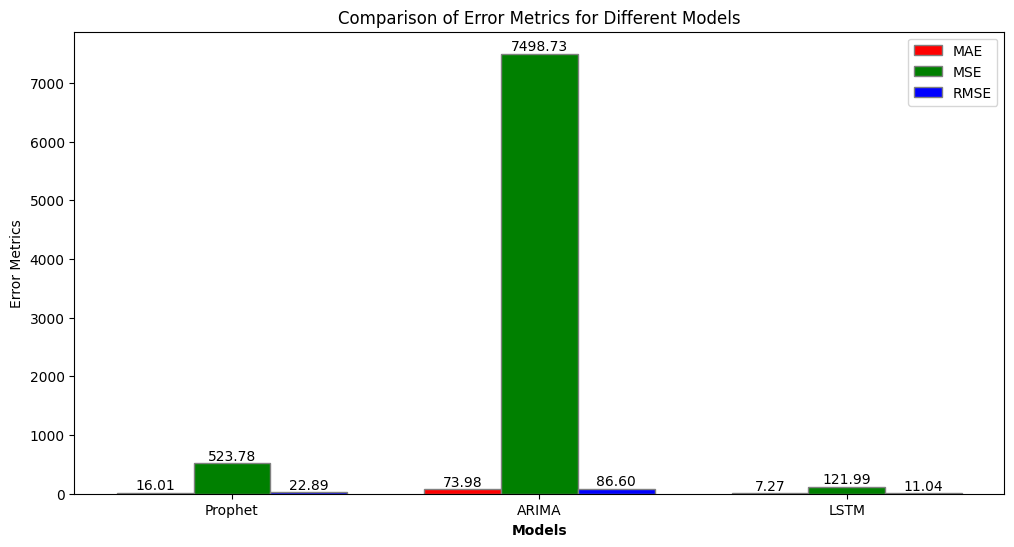

In [7]:

# Plot the comparison
plt.figure(figsize=(12, 6))

bar_width = 0.25
bar1 = np.arange(len(results_comparison['Model']))
bar2 = [i + bar_width for i in bar1]
bar3 = [i + bar_width for i in bar2]

bars1 = plt.bar(bar1, results_comparison['MAE'], color='r', width=bar_width, edgecolor='grey', label='MAE')
bars2 = plt.bar(bar2, results_comparison['MSE'], color='g', width=bar_width, edgecolor='grey', label='MSE')
bars3 = plt.bar(bar3, results_comparison['RMSE'], color='b', width=bar_width, edgecolor='grey', label='RMSE')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Error Metrics')
plt.xticks([r + bar_width for r in range(len(results_comparison['Model']))], results_comparison['Model'])
plt.legend()

plt.title('Comparison of Error Metrics for Different Models')

# Adding the text on top of the bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom'
        )

plt.show()


Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0142 - val_loss: 0.0036
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0011 - val_loss: 9.4505e-04
Epoch 9/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0012 - val_loss: 9.6779e-04
Epoch 10/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0010 - val_loss: 9.4217e-04
Epoch 11/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0011 - val_loss: 8.9248e-04
Epoch 12/20
244/244 ━━━━━

01:10:34 - cmdstanpy - INFO - Chain [1] start processing
01:10:35 - cmdstanpy - INFO - Chain [1] done processing


           Model        MAE           MSE        RMSE
0        Prophet  83.294555  11719.615408  108.257173
1          ARIMA  73.976301   7498.730896   86.595213
2           LSTM   7.590751    129.358303   11.373579
3  Random Forest   4.573386     50.622484    7.114948
4            SVR  24.589767    781.722188   27.959295


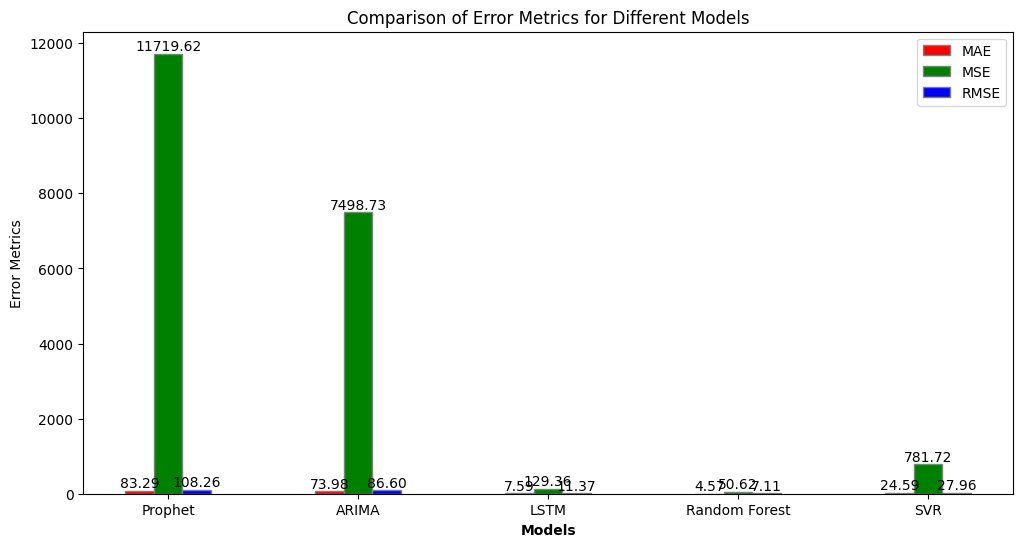

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the datasets
file_paths = [
    'Dataset 1_EV charging reports_cleaned.csv',
    'Dataset 2_Hourly EV loads - Per user_cleaned.csv',
    'Dataset 3a_Hourly EV loads - Aggregated private_cleaned.csv',
    'Dataset 3b_Hourly EV loads - Aggregated shared_cleaned.csv',
    'Dataset 5_AMS data from garage Bl2_cleaned.csv',
    'Dataset 6_Local traffic distribution_cleaned.csv',
    'Norway_Trondheim_ExactLoc_Weather.csv'
]

dataframes = [pd.read_csv(file) for file in file_paths]

# Select Dataset 2 for prediction
ev_loads_per_user = dataframes[1]

# Preprocessing steps
# Convert date_from and date_to to datetime objects
ev_loads_per_user['date_from'] = pd.to_datetime(ev_loads_per_user['date_from'], format='%d.%m.%Y %H:%M')
ev_loads_per_user['date_to'] = pd.to_datetime(ev_loads_per_user['date_to'], format='%d.%m.%Y %H:%M')

# Convert load columns to numeric values (handling commas and converting to float)
load_columns = ['Synthetic_3_6kW', 'Synthetic_7_2kW', 'Flex_3_6kW', 'Flex_7_2kW']
for column in load_columns:
    ev_loads_per_user[column] = ev_loads_per_user[column].str.replace(',', '.').astype(float)

# Handle missing values by filling them with 0
ev_loads_per_user[load_columns] = ev_loads_per_user[load_columns].fillna(0)

# Extract hour from 'date_from'
ev_loads_per_user['hour'] = ev_loads_per_user['date_from'].dt.floor('h')

# Aggregating data by hour and summing only the load columns
ev_loads_per_hour = ev_loads_per_user.groupby('hour')[load_columns].sum().reset_index()

# Define the target variable (total load as the sum of all load columns)
ev_loads_per_hour['total_load'] = ev_loads_per_hour[load_columns].sum(axis=1)

# Select features and target
features = ev_loads_per_hour[['hour'] + load_columns]
target = ev_loads_per_hour['total_load']

# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features[load_columns])
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

# Create sequences for LSTM (using a window of 24 hours)
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(features_scaled, target_scaled, window_size)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(window_size, len(load_columns))))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate regression evaluation metrics for LSTM
mae_lstm = mean_absolute_error(y_test_actual, predictions)
mse_lstm = mean_squared_error(y_test_actual, predictions)
rmse_lstm = np.sqrt(mse_lstm)

# Prepare data for ARIMA
total_load = ev_loads_per_hour['total_load']

# Split data into training and testing sets
train_size = int(len(total_load) * 0.8)
train, test = total_load[:train_size], total_load[train_size:]

# Fit the ARIMA model
model_arima = ARIMA(train, order=(5, 1, 0))
model_fit_arima = model_arima.fit()

# Make predictions
predictions_arima = model_fit_arima.forecast(steps=len(test))

# Calculate evaluation metrics for ARIMA
mae_arima = mean_absolute_error(test, predictions_arima)
mse_arima = mean_squared_error(test, predictions_arima)
rmse_arima = np.sqrt(mse_arima)

# Prepare data for Prophet
data_prophet = ev_loads_per_hour[['hour', 'total_load']].rename(columns={'hour': 'ds', 'total_load': 'y'})

# Split the data
train_prophet = data_prophet.iloc[:train_size]
test_prophet = data_prophet.iloc[train_size:]

# Fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_prophet)

# Make predictions
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='h')
forecast = model_prophet.predict(future)

# Ensure the predictions are in float64
predictions_prophet = forecast['yhat'].iloc[-len(test_prophet):].astype(np.float64)
test_values = test_prophet['y'].astype(np.float64)

# Calculate evaluation metrics for Prophet
mae_prophet = mean_absolute_error(test_values, predictions_prophet)
mse_prophet = mean_squared_error(test_values, predictions_prophet)
rmse_prophet = np.sqrt(mse_prophet)

# Train and evaluate Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(features_scaled[:train_size], target_scaled[:train_size].ravel())
rf_predictions = rf_model.predict(features_scaled[train_size:])
rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1)).ravel()
rf_test_actual = scaler.inverse_transform(target_scaled[train_size:].reshape(-1, 1)).ravel()

mae_rf = mean_absolute_error(rf_test_actual, rf_predictions)
mse_rf = mean_squared_error(rf_test_actual, rf_predictions)
rmse_rf = np.sqrt(mse_rf)

# Train and evaluate SVR model
svr_model = SVR()
svr_model.fit(features_scaled[:train_size], target_scaled[:train_size].ravel())
svr_predictions = svr_model.predict(features_scaled[train_size:])
svr_predictions = scaler.inverse_transform(svr_predictions.reshape(-1, 1)).ravel()
svr_test_actual = scaler.inverse_transform(target_scaled[train_size:].reshape(-1, 1)).ravel()

mae_svr = mean_absolute_error(svr_test_actual, svr_predictions)
mse_svr = mean_squared_error(svr_test_actual, svr_predictions)
rmse_svr = np.sqrt(mse_svr)

# Create a DataFrame to compare the results
results_comparison = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA', 'LSTM', 'Random Forest', 'SVR'],
    'MAE': [mae_prophet, mae_arima, mae_lstm, mae_rf, mae_svr],
    'MSE': [mse_prophet, mse_arima, mse_lstm, mse_rf, mse_svr],
    'RMSE': [rmse_prophet, rmse_arima, rmse_lstm, rmse_rf, rmse_svr]
})

# Display the DataFrame
print(results_comparison)

# Plot the comparison
plt.figure(figsize=(12, 6))

bar_width = 0.15
bar1 = np.arange(len(results_comparison['Model']))
bar2 = [i + bar_width for i in bar1]
bar3 = [i + bar_width for i in bar2]

bars1 = plt.bar(bar1, results_comparison['MAE'], color='r', width=bar_width, edgecolor='grey', label='MAE')
bars2 = plt.bar(bar2, results_comparison['MSE'], color='g', width=bar_width, edgecolor='grey', label='MSE')
bars3 = plt.bar(bar3, results_comparison['RMSE'], color='b', width=bar_width, edgecolor='grey', label='RMSE')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Error Metrics')
plt.xticks([r + bar_width for r in range(len(results_comparison['Model']))], results_comparison['Model'])
plt.legend()

plt.title('Comparison of Error Metrics for Different Models')

# Adding the text on top of the bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom'
        )

plt.show()


In [11]:
# Save the LSTM model
model.save('lstm_model.h5')

In [12]:
import joblib

# Save the Random Forest model
joblib.dump(rf_model, 'random_forest_model.h5')

# Save the SVR model
joblib.dump(svr_model, 'svr_model.h5')

['svr_model.h5']

In [13]:
# Save the ARIMA model
joblib.dump(model_fit_arima, 'arima_model.h5')

# Save the Prophet model
model_prophet.stan_backend.logger = None  # Disabling the logger for clean saving
with open('prophet_model.h5', 'wb') as f:
    joblib.dump(model_prophet, f)
